In [1]:
%run setup.py
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from wordcloud import WordCloud
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS as sk_stop
import numpy as np, re

In [2]:
# Load and clean the dataset
train_df = pd.read_csv("../data/splits/train.csv")
train_df = train_df.dropna(subset=["question1", "question2"])
sampled = train_df.sample(n=32_000, random_state=13).copy() # approx. 10% of train since 0.8*400k=320k

# Add length and word count features
sampled['q1_len'] = sampled['question1'].astype(str).apply(len)
sampled['q2_len'] = sampled['question2'].astype(str).apply(len)
sampled['q1_words'] = sampled['question1'].astype(str).apply(lambda x: len(x.split()))
sampled['q2_words'] = sampled['question2'].astype(str).apply(lambda x: len(x.split()))

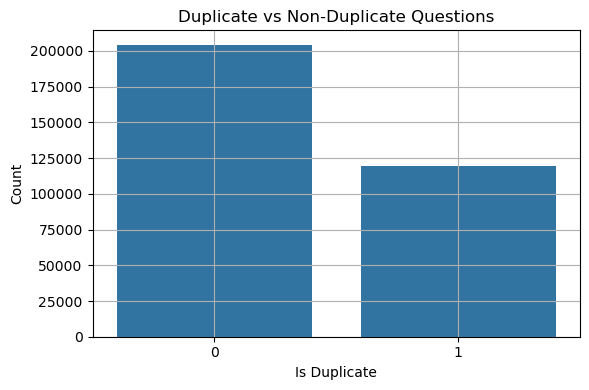

In [3]:
# 1. Class balance
plt.figure(figsize=(6, 4))
sns.countplot(x='is_duplicate', data=train_df)
plt.title('Duplicate vs Non-Duplicate Questions')
plt.xlabel('Is Duplicate')
plt.ylabel('Count')
plt.grid(True)
plt.tight_layout()
plt.show()

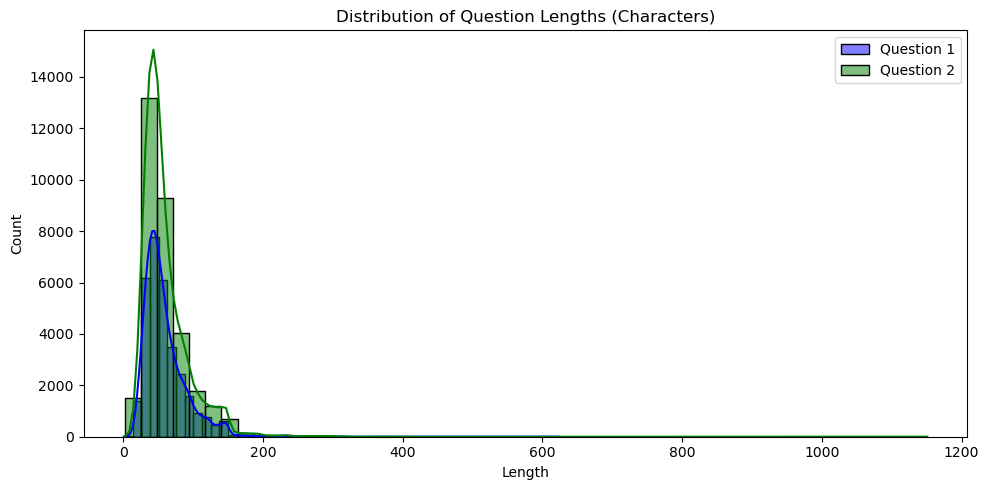

In [4]:
# 2. Question length in characters
plt.figure(figsize=(10, 5))
sns.histplot(sampled['q1_len'], bins=50, color='blue', label='Question 1', kde=True)
sns.histplot(sampled['q2_len'], bins=50, color='green', label='Question 2', kde=True)
plt.title('Distribution of Question Lengths (Characters)')
plt.xlabel('Length')
plt.legend()
plt.tight_layout()
plt.show()

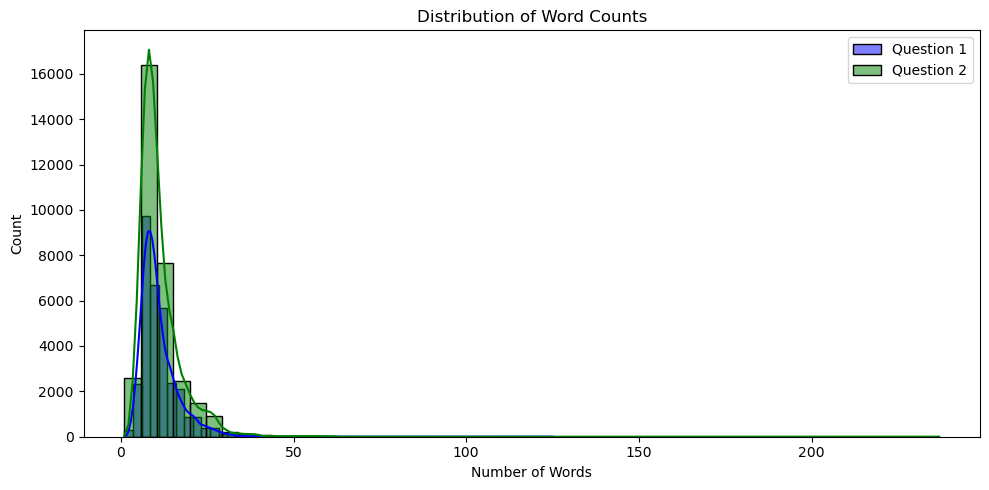

In [5]:
# 3. Word count distribution
plt.figure(figsize=(10, 5))
sns.histplot(sampled['q1_words'], bins=50, color='blue', label='Question 1', kde=True)
sns.histplot(sampled['q2_words'], bins=50, color='green', label='Question 2', kde=True)
plt.title('Distribution of Word Counts')
plt.xlabel('Number of Words')
plt.legend()
plt.tight_layout()
plt.show()

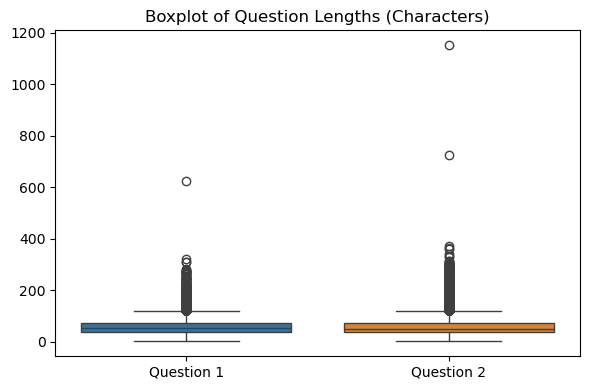

In [6]:
# 4. Boxplot for question lengths
plt.figure(figsize=(6, 4))
sns.boxplot(data=sampled[['q1_len', 'q2_len']])
plt.title('Boxplot of Question Lengths (Characters)')
plt.xticks([0, 1], ['Question 1', 'Question 2'])
plt.tight_layout()
plt.show()

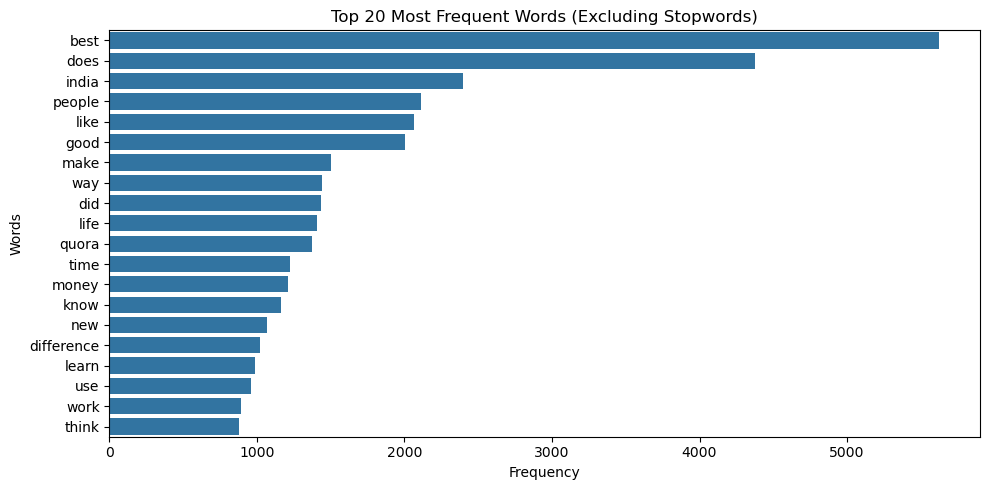

In [7]:
# 5. Most frequent words
vectorizer = CountVectorizer(stop_words='english', max_features=20)
X = vectorizer.fit_transform(sampled['question1'] + " " + sampled['question2'])
word_freq = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out()).sum().sort_values(ascending=False)

plt.figure(figsize=(10, 5))
sns.barplot(x=word_freq.values, y=word_freq.index)
plt.title("Top 20 Most Frequent Words (Excluding Stopwords)")
plt.xlabel("Frequency")
plt.ylabel("Words")
plt.tight_layout()
plt.show()

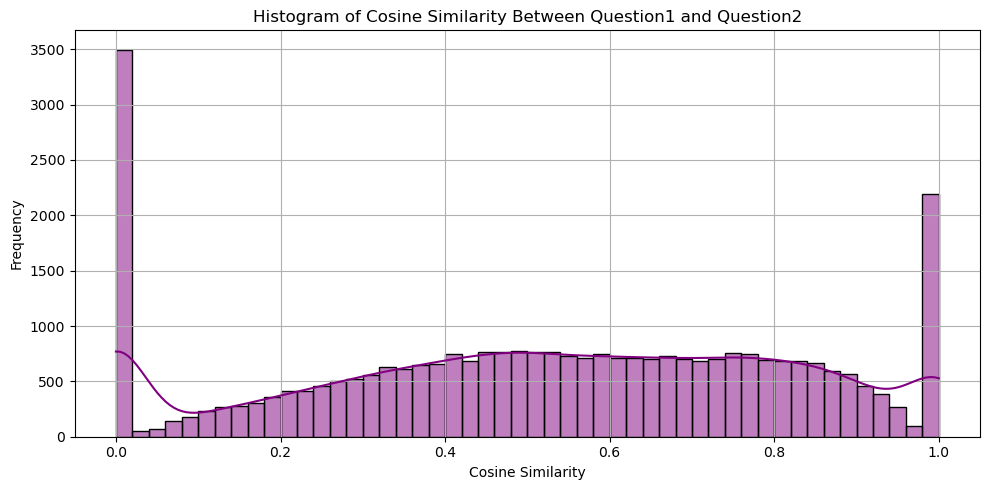

In [8]:
# 6. Cosine similarity histogram
tfidf = TfidfVectorizer(stop_words='english')
tfidf_q1 = tfidf.fit_transform(sampled['question1'])
tfidf_q2 = tfidf.transform(sampled['question2'])

sampled['cosine_similarity'] = [
    cosine_similarity(tfidf_q1[i], tfidf_q2[i])[0][0] for i in range(len(sampled))
]

plt.figure(figsize=(10, 5))
sns.histplot(sampled['cosine_similarity'], bins=50, kde=True, color='purple')
plt.title('Histogram of Cosine Similarity Between Question1 and Question2')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()

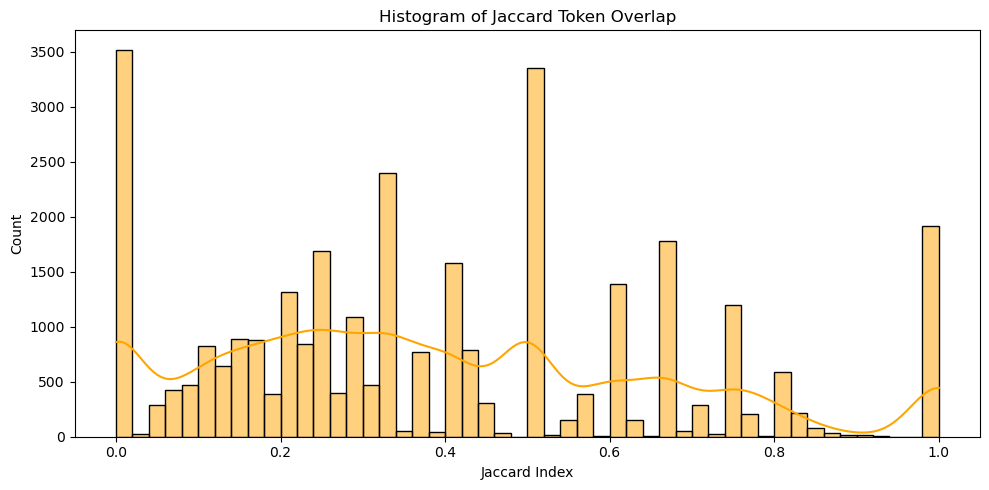

Corr(jaccard, is_duplicate) = 0.388


In [9]:
# 7. Jaccard token overlap
tokeniser = re.compile(r"[A-Za-z0-9']+")

def jaccard(a: str, b: str) -> float:
    s1 = {t for t in tokeniser.findall(a.lower()) if t not in sk_stop}
    s2 = {t for t in tokeniser.findall(b.lower()) if t not in sk_stop}
    return len(s1 & s2) / (len(s1 | s2) or 1)

sampled["jaccard"] = sampled.apply(
    lambda r: jaccard(r.question1, r.question2), axis=1
)

plt.figure(figsize=(10,5))
sns.histplot(sampled["jaccard"], bins=50, kde=True, color="orange")
plt.title("Histogram of Jaccard Token Overlap")
plt.xlabel("Jaccard Index"); plt.tight_layout(); plt.show()

print("Corr(jaccard, is_duplicate) =",
      sampled[["jaccard", "is_duplicate"]].corr().iloc[0,1].round(3))

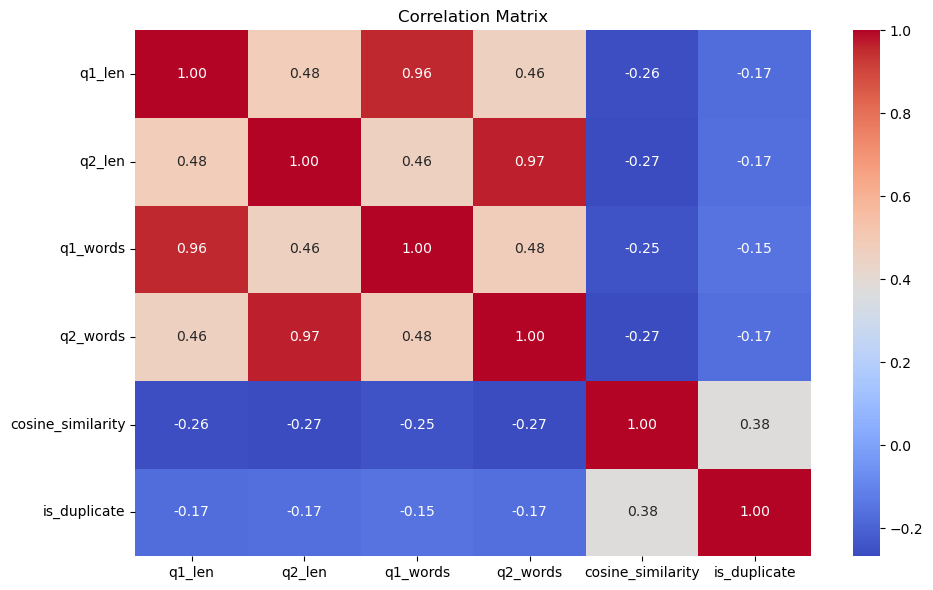

In [10]:
# 7. Correlation heatmap
correlation = sampled[['q1_len', 'q2_len', 'q1_words', 'q2_words', 'cosine_similarity', 'is_duplicate']].corr()
plt.figure(figsize=(10, 6))
sns.heatmap(correlation, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()

/tmp/ipykernel_9459/3083102593.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dup_rate = sampled.groupby(bins)["is_duplicate"].mean()


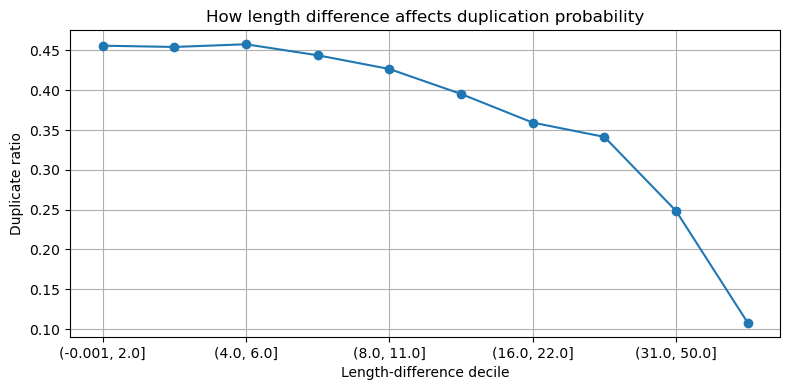

In [11]:
# 8. Length-difference vs. duplicate rate
sampled["len_diff"] = abs(sampled["q1_len"] - sampled["q2_len"])
bins = pd.qcut(sampled["len_diff"], 10, duplicates="drop")
dup_rate = sampled.groupby(bins)["is_duplicate"].mean()

plt.figure(figsize=(8,4))
dup_rate.plot(marker="o")
plt.ylabel("Duplicate ratio")
plt.xlabel("Length-difference decile")
plt.title("How length difference affects duplication probability")
plt.grid(True); plt.tight_layout(); plt.show()

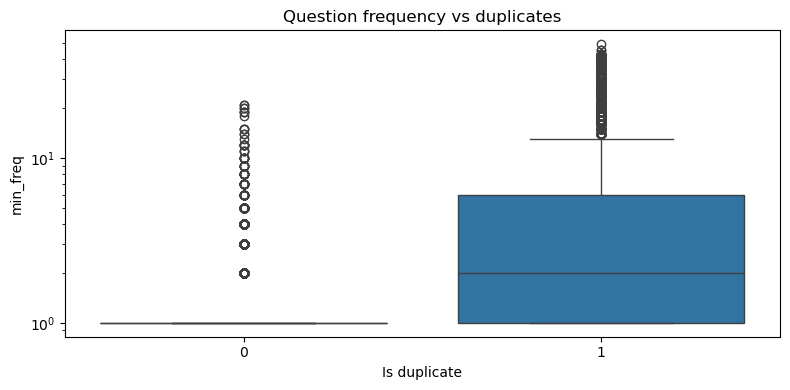

Corr(min_freq, is_duplicate) = 0.401


In [12]:
# 9. “Magic” frequency feature preview 
# degree = how many times each qid appears in the TRAIN set
freq = pd.concat([train_df.qid1, train_df.qid2]).value_counts()

sampled["q1_freq"] = sampled["qid1"].map(freq)
sampled["q2_freq"] = sampled["qid2"].map(freq)
sampled["min_freq"] = sampled[["q1_freq","q2_freq"]].min(axis=1)

plt.figure(figsize=(8,4))
sns.boxplot(x=sampled["is_duplicate"], y=sampled["min_freq"])
plt.yscale("log"); plt.xlabel("Is duplicate"); plt.title("Question frequency vs duplicates")
plt.tight_layout(); plt.show()

print("Corr(min_freq, is_duplicate) =",
      sampled[["min_freq","is_duplicate"]].corr().iloc[0,1].round(3))

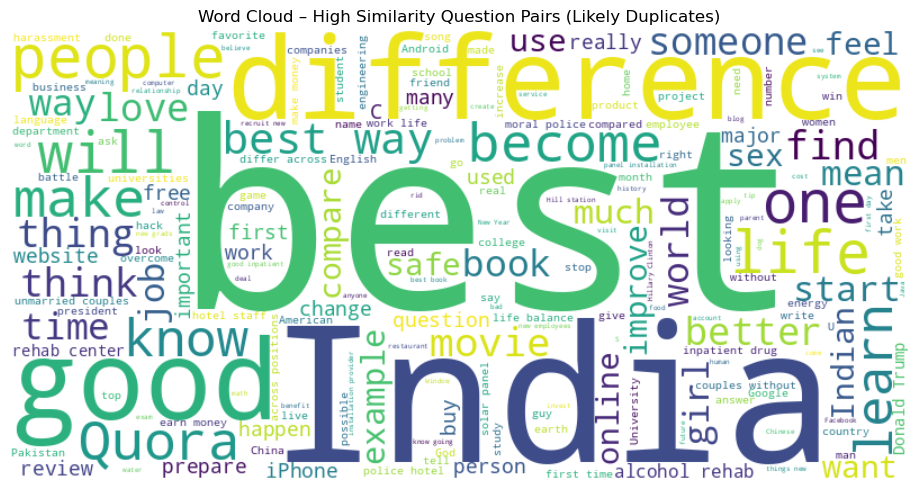

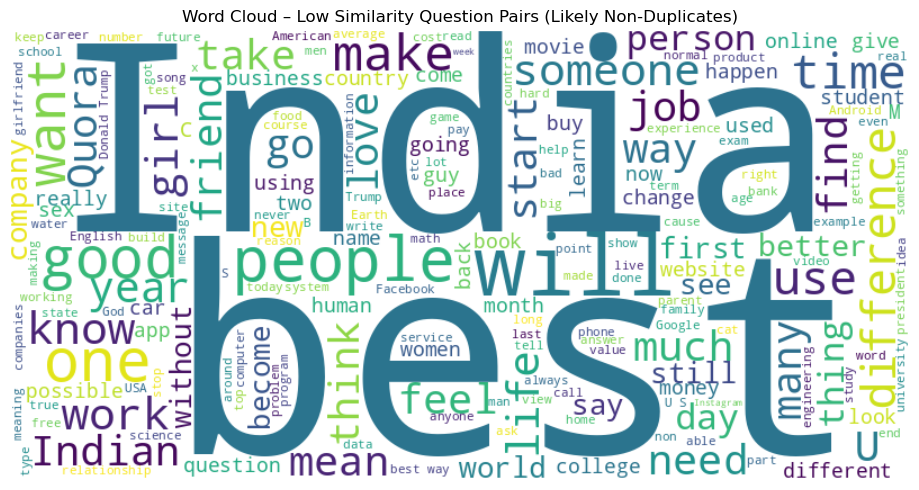

In [13]:
# 8. Word clouds (high and low similarity)
dup_text = " ".join(sampled[sampled['cosine_similarity'] > 0.8]['question1'].astype(str)) + \
           " " + " ".join(sampled[sampled['cosine_similarity'] > 0.8]['question2'].astype(str))

nondup_text = " ".join(sampled[sampled['cosine_similarity'] < 0.2]['question1'].astype(str)) + \
              " " + " ".join(sampled[sampled['cosine_similarity'] < 0.2]['question2'].astype(str))

# Word cloud for duplicates
wordcloud_dup = WordCloud(width=800, height=400, background_color='white').generate(dup_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_dup, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud – High Similarity Question Pairs (Likely Duplicates)")
plt.tight_layout()
plt.show()

# Word cloud for non-duplicates
wordcloud_nondup = WordCloud(width=800, height=400, background_color='white').generate(nondup_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_nondup, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud – Low Similarity Question Pairs (Likely Non-Duplicates)")
plt.tight_layout()
plt.show()

In [14]:
# === Cell A — summary table =========================================
import pandas as pd
from tabulate import tabulate            # pip install tabulate (tiny dep)

summary = pd.DataFrame({
    "metric": [
        "train rows",
        "dup count (1)",
        "non-dup count (0)",
        "dup ratio",
        "mean q1 chars",
        "mean q2 chars",
        "mean q1 words",
        "mean q2 words",
        "mean len diff (abs)",
        "mean Jaccard",
        "mean cosine TF-IDF"
    ],
    "value": [
        len(train_df),
        int(train_df["is_duplicate"].sum()),
        int((1-train_df["is_duplicate"]).sum()),
        f"{train_df['is_duplicate'].mean():.3%}",
        f"{sampled['q1_len'].mean():.1f}",
        f"{sampled['q2_len'].mean():.1f}",
        f"{sampled['q1_words'].mean():.1f}",
        f"{sampled['q2_words'].mean():.1f}",
        f"{sampled['len_diff'].mean():.1f}",
        f"{sampled['jaccard'].mean():.3f}",
        f"{sampled['cosine_similarity'].mean():.3f}"
    ]
})

print(tabulate(summary, headers="keys", tablefmt="github", showindex=False))


| metric              | value   |
|---------------------|---------|
| train rows          | 323554  |
| dup count (1)       | 119327  |
| non-dup count (0)   | 204227  |
| dup ratio           | 36.880% |
| mean q1 chars       | 59.3    |
| mean q2 chars       | 60.1    |
| mean q1 words       | 10.9    |
| mean q2 words       | 11.2    |
| mean len diff (abs) | 20.2    |
| mean Jaccard        | 0.388   |
| mean cosine TF-IDF  | 0.522   |


In [15]:
# === Cell B — correlations & duplicate-rate by bins ================

# 1. Numeric correlations
corr = sampled[["jaccard","cosine_similarity","len_diff",
                "q1_len","q2_len","is_duplicate"]].corr()["is_duplicate"].drop("is_duplicate")
print("\nCorrelation w/ is_duplicate:")
print(corr.round(3).to_string())

# 2. Duplicate ratio by length-difference decile
bins = pd.qcut(sampled["len_diff"], 10, duplicates="drop")
dup_rate = sampled.groupby(bins)["is_duplicate"].mean().to_frame("dup_ratio")
print("\nDuplicate ratio by len_diff decile:")
print(tabulate(dup_rate.reset_index(), headers="keys", tablefmt="github", showindex=False))

# 3. Duplicate ratio by min(question frequency) quartile
freq = pd.concat([train_df.qid1, train_df.qid2]).value_counts()
sampled["min_freq"] = sampled[["qid1","qid2"]].apply(lambda r: min(freq[r[0]], freq[r[1]]), axis=1)
quart = pd.qcut(sampled["min_freq"], 4, duplicates="drop")
dup_rate_freq = sampled.groupby(quart)["is_duplicate"].mean().to_frame("dup_ratio")
print("\nDuplicate ratio by min_freq quartile:")
print(tabulate(dup_rate_freq.reset_index(), headers="keys", tablefmt="github", showindex=False))



Correlation w/ is_duplicate:
jaccard              0.388
cosine_similarity    0.375
len_diff            -0.211
q1_len              -0.168
q2_len              -0.168

Duplicate ratio by len_diff decile:
| len_diff       |   dup_ratio |
|----------------|-------------|
| (-0.001, 2.0]  |    0.455956 |
| (2.0, 4.0]     |    0.454344 |
| (4.0, 6.0]     |    0.457738 |
| (6.0, 8.0]     |    0.443927 |
| (8.0, 11.0]    |    0.426697 |
| (11.0, 16.0]   |    0.395349 |
| (16.0, 22.0]   |    0.359344 |
| (22.0, 31.0]   |    0.341378 |
| (31.0, 50.0]   |    0.248376 |
| (50.0, 1037.0] |    0.107856 |


/tmp/ipykernel_9459/2587420784.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dup_rate = sampled.groupby(bins)["is_duplicate"].mean().to_frame("dup_ratio")
/tmp/ipykernel_9459/2587420784.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sampled["min_freq"] = sampled[["qid1","qid2"]].apply(lambda r: min(freq[r[0]], freq[r[1]]), axis=1)



Duplicate ratio by min_freq quartile:
| min_freq     |   dup_ratio |
|--------------|-------------|
| (0.999, 2.0] |    0.256338 |
| (2.0, 49.0]  |    0.870643 |


/tmp/ipykernel_9459/2587420784.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dup_rate_freq = sampled.groupby(quart)["is_duplicate"].mean().to_frame("dup_ratio")


In [16]:
# === Cell C — duplicate-rate by similarity deciles =================
for col in ["cosine_similarity", "jaccard"]:
    bins = pd.qcut(sampled[col], 10, duplicates="drop")
    rate = sampled.groupby(bins)["is_duplicate"].mean().to_frame("dup_ratio")
    print(f"\nDuplicate ratio by {col} decile:")
    print(tabulate(rate.reset_index(), headers="keys",
                   tablefmt="github", showindex=False))


Duplicate ratio by cosine_similarity decile:
| cosine_similarity   |   dup_ratio |
|---------------------|-------------|
| (-0.001, 0.249]     |   0.0523438 |
| (0.249, 0.364]      |   0.2575    |
| (0.364, 0.455]      |   0.362187  |
| (0.455, 0.538]      |   0.40875   |
| (0.538, 0.627]      |   0.470625  |
| (0.627, 0.717]      |   0.4975    |
| (0.717, 0.806]      |   0.4725    |
| (0.806, 0.909]      |   0.4825    |
| (0.909, 1.0]        |   0.652813  |

Duplicate ratio by jaccard decile:
| jaccard         |   dup_ratio |
|-----------------|-------------|
| (-0.001, 0.143] |   0.0198714 |
| (0.143, 0.214]  |   0.195822  |
| (0.214, 0.286]  |   0.366675  |
| (0.286, 0.333]  |   0.462552  |
| (0.333, 0.429]  |   0.519678  |
| (0.429, 0.5]    |   0.544372  |
| (0.5, 0.667]    |   0.524535  |
| (0.667, 0.75]   |   0.477593  |
| (0.75, 1.0]     |   0.619727  |


/tmp/ipykernel_9459/230264013.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rate = sampled.groupby(bins)["is_duplicate"].mean().to_frame("dup_ratio")
/tmp/ipykernel_9459/230264013.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rate = sampled.groupby(bins)["is_duplicate"].mean().to_frame("dup_ratio")


| Signal                                                | Evidence                                                        | What we’ll do in `features.py`                                                     |
| ----------------------------------------------------- | --------------------------------------------------------------- | ---------------------------------------------------------------------------------- |
| **Jaccard  ≈ 0.39** (corr) & **TF-IDF cosine ≈ 0.38** | Strongest linear link to `is_duplicate`                         | Keep both as raw numeric features                                                |
| **Length difference (len\_diff) ≈ –0.21**             | Duplicate probability drops sharply once len Δ > 25 chars       | Include: <br>   • raw `len_diff` (float)<br>   • 10-bin ordinal bucket (one-hot) |
| **Question frequency (min\_freq)**                    | Dup-ratio jumps from 26 % → 87 % between lower & upper quartile | Log-transform `min_freq` then 4-bin bucket (one-hot)                             |
| **q1/q2 lengths & word counts**                       | Mild negative corr (\~-0.17)                                    | Keep raw values; light regularisation handles low info                           |